In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import seaborn as sns
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder


In [11]:
# Define data types for each column
dtype_options = {
    'OorzaakCode': 'string'
}

# Read the CSV file with specified data types
df = pd.read_csv('full_dataset.csv', dtype=dtype_options)

# Remove traffic cause columns
columns_to_remove = [ 'OorzaakGronddetail', 'OorzaakVerloop', 'OorzaakCodeVerloop', 'Oorzaak_1', 'Oorzaak_2', 'Oorzaak_3', 'Oorzaak_4'
]

df = df.drop(columns=columns_to_remove)

# Convert date columns to datetime
df['DatumFileBegin'] = pd.to_datetime(df['DatumFileBegin'], format="%Y-%m-%d")
df['Year'] = df['DatumFileBegin'].dt.year


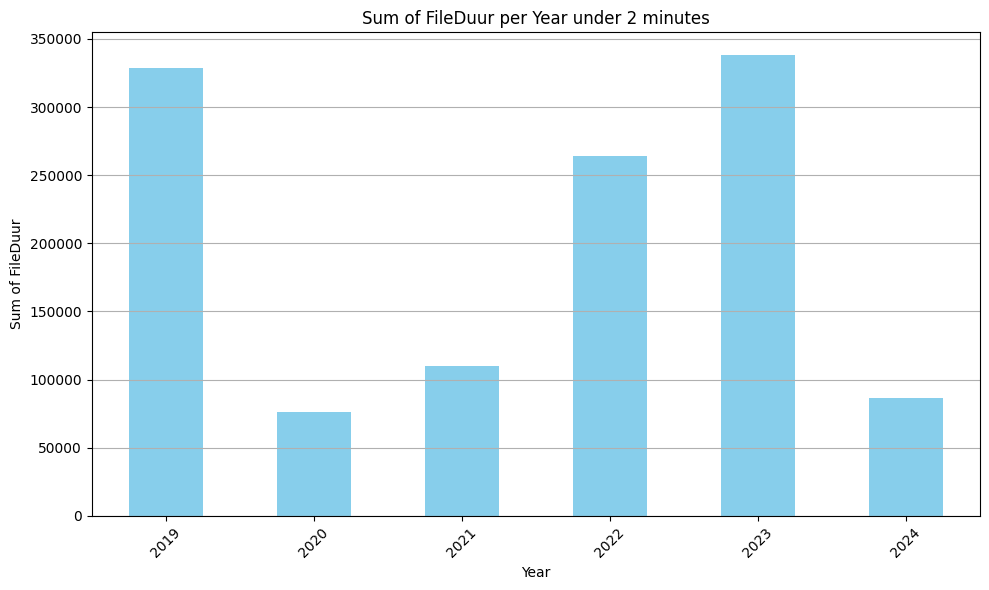

In [23]:
df =df[df['RouteOms'] == 'A4']
perc = df[df['FileDuur']< 2]
# Group the data by 'Year' and sum the 'FileZwaarte' values
yearly_sum = df.groupby('Year')['FileDuur'].sum()

# Plot the data
plt.figure(figsize=(10, 6))
yearly_sum.plot(kind='bar', color='skyblue')
plt.title('Sum of FileDuur per Year under 2 minutes')
plt.xlabel('Year')
plt.ylabel('Sum of FileDuur')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

In [16]:
yearly_sum

Year
2019     18025.613
2020      3549.311
2021      1950.259
2022    107724.228
2023    154626.316
2024     37786.839
Name: FileDuur, dtype: float64

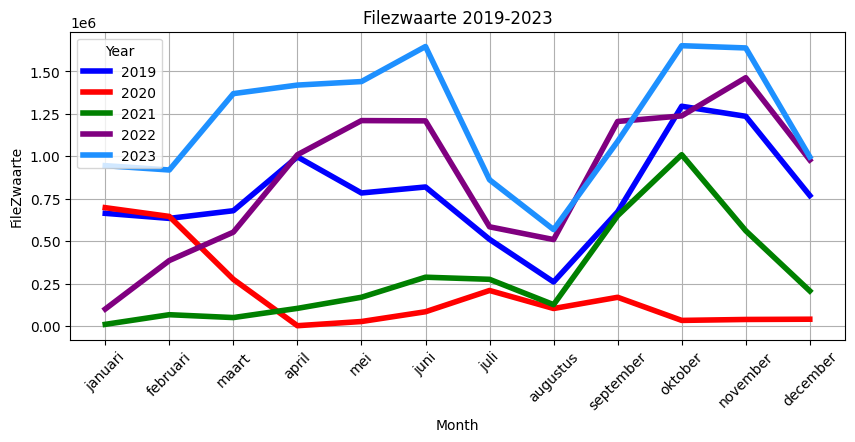

In [19]:
# Ensure DatumFileBegin is in datetime format
df['DatumFileBegin'] = pd.to_datetime(df['DatumFileBegin'])

# Extract year and month from DatumFileBegin
df['Year'] = df['DatumFileBegin'].dt.year
df['Month'] = df['DatumFileBegin'].dt.month

# Group by year and month and calculate the sum of FileZwaarte
df_grouped = df[df['Year']<2024]
df_grouped = df_grouped.groupby(['Year', 'Month'])['FileZwaarte'].sum().reset_index()

# Pivot the table to have years as columns and months as rows
pivot_table = df_grouped.pivot(index='Month', columns='Year', values='FileZwaarte')

# Specify colors for each year
year_colors = {
    2019: 'blue',
    2020: 'red',
    2021: 'green',
    2022: 'purple',
    2023: 'dodgerblue'
}

# Plot the data
plt.figure(figsize=(10, 4))
for year in pivot_table.columns:
    plt.plot(pivot_table.index, pivot_table[year], label=str(year), linewidth=4, color=year_colors[year])   # Set linewidth to 2.5




plt.title('Filezwaarte 2019-2023')
plt.xlabel('Month')
plt.ylabel('FileZwaarte')
plt.legend(title='Year')
plt.grid(True)
plt.xticks(range(1, 13), ['januari', 'februari', 'maart', 'april', 'mei', 'juni', 'juli', 'augustus', 'september', 'oktober', 'november', 'december'],            
           rotation=45)
plt.show()

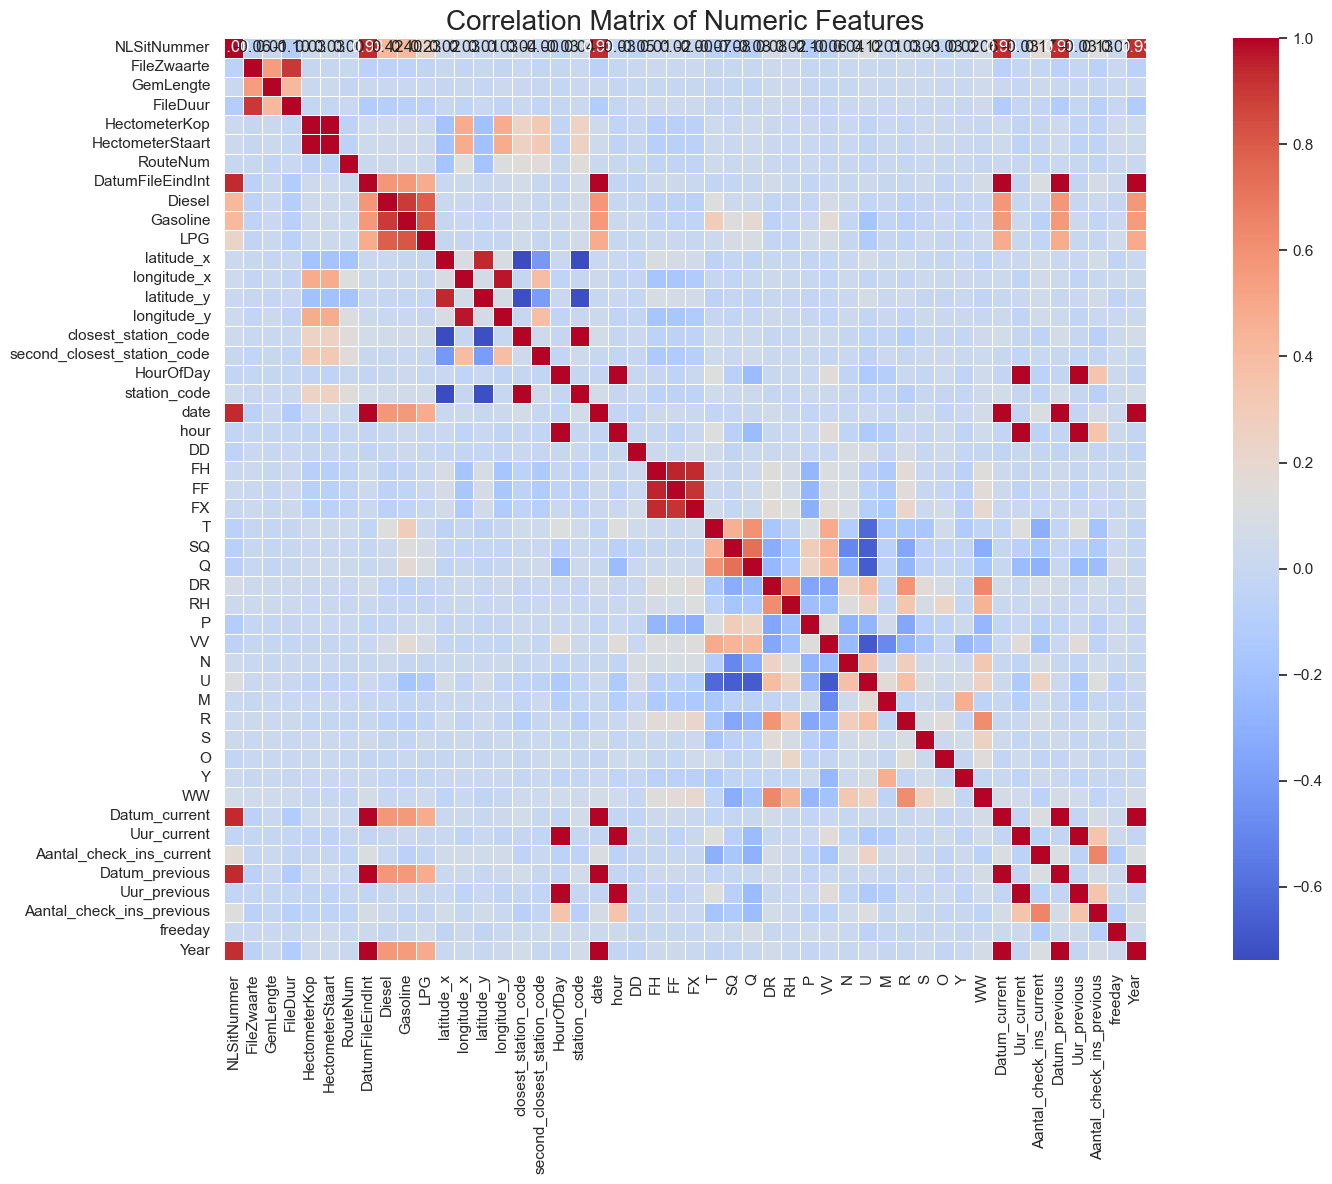

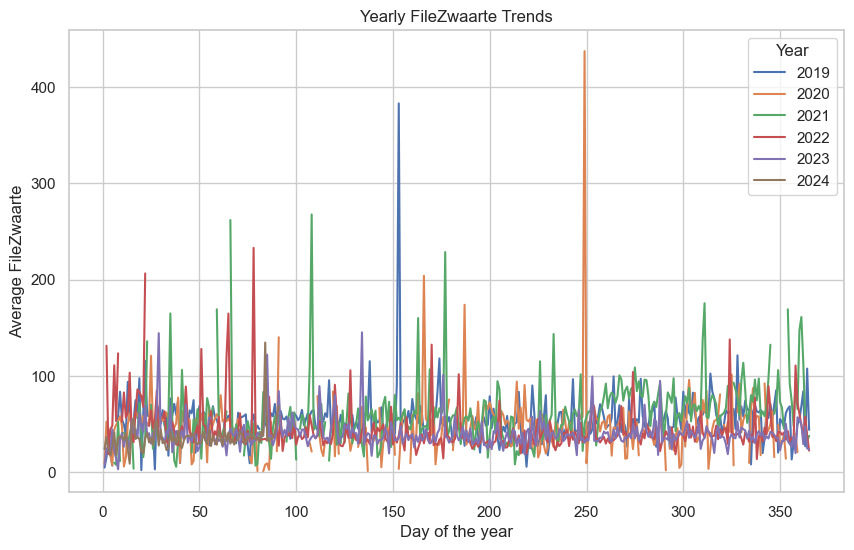

In [4]:

# Assuming traffic_df is your DataFrame
numeric_df = df.select_dtypes(include=[np.number])  # Selecting only numeric columns

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Set a clean whitegrid style for better visibility
sns.set(style="whitegrid")

# Create a larger figure to accommodate all annotations
plt.figure(figsize=(18,12))  # Increased size

# Generate the heatmap with annotations for all cells
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True)

plt.title('Correlation Matrix of Numeric Features', fontsize=20)

# Improve the layout to prevent clipping of tick labels and titles
plt.tight_layout()

# Show the plot
plt.show()

# Convert DatumFileBeginInt to datetime format
df['Date'] = pd.to_datetime(df['DatumFileBeginInt'].astype(str))

# Extract the year from the Date
df['Year'] = df['Date'].dt.year

# Group the data by Year and calculate mean FileZwaarte (or change to sum, max, etc., as needed)
yearly_data = df.groupby('Year')['FileZwaarte'].mean().reset_index()

# Creating a pivot table to have years on the columns and dates on the index
pivot_table = df.pivot_table(values='FileZwaarte', index=df['Date'].dt.dayofyear, columns='Year', aggfunc='mean')

# Plotting
plt.figure(figsize=(10, 6))
for column in pivot_table.columns:
    plt.plot(pivot_table.index, pivot_table[column], label=column)
plt.title('Yearly FileZwaarte Trends')
plt.xlabel('Day of the year')
plt.ylabel('Average FileZwaarte')
plt.legend(title='Year')
plt.show()

In [ ]:
# Remove extreme outliers
# Calculate Z-scores
z_scores_fd = stats.zscore(df['FileDuur'])
z_scores_gl = stats.zscore(df['GemLengte'])
z_scores_fz = stats.zscore(df['FileZwaarte'])

# Filter data based on Z-scores
df = df[
    (abs(z_scores_fd) < 3) & (abs(z_scores_gl) < 3) & (abs(z_scores_fz) < 3)
]


In [ ]:
# Count missing values
missing_values = df.isnull().sum()

# Total values
total_values = df.shape[0]

# Calculate percentage of missing values
percentage_missing = (missing_values / total_values) * 100

# Create a DataFrame for the missing value frequency table
missing_value_table = pd.DataFrame({
    'Total Values': total_values,
    'Missing Values': missing_values,
    'Percentage Missing': percentage_missing
})

columns_to_remove = [ 'WW', 'VV', 'SQ']

# Filter the DataFrame to include only the columns to keep
df = df.drop(columns=columns_to_remove)

median_imputer = SimpleImputer(strategy='median')
mean_imputer = SimpleImputer(strategy='mean')

# Imputing 'FH' with median due to potential outliers in wind speeds
df['FH'] = median_imputer.fit_transform(df[['FH']])

# Imputing 'SQ' with median to handle any extreme variability
df['Q'] = median_imputer.fit_transform(df[['Q']])

# Imputing 'P' with mean, considering the general stability of air pressure readings
df['P'] = mean_imputer.fit_transform(df[['P']])

# Imputing 'N' with mean
df['N'] = median_imputer.fit_transform(df[['N']])

missing_value_table[missing_value_table['Missing Values'] > 0]  


,Total Values,Missing Values,Percentage Missing
FH,954055,71,0.007442
SQ,954055,4566,0.478589
Q,954055,4637,0.486031
P,954055,17963,1.882805
VV,954055,65010,6.814073
N,954055,19812,2.076610
WW,954055,936585,98.168869


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.show()

In [ ]:
# Feature creation before removal
# Create a new column 'DayOfWeek' by extracting the day of the week from the 'DatumFileBegin' column
df['DayOfWeek'] = df['DatumFileBegin'].dt.dayofweek + 1
df['MonthOfYear'] = df['DatumFileBegin'].dt.month

# Convert columns to datetime format
df['TijdFileBegin'] = pd.to_datetime(df['TijdFileBegin'], format='%H:%M:%S')
df['TijdFileEind'] = pd.to_datetime(df['TijdFileEind'], format='%H:%M:%S')

# Function to convert time to seconds since midnight
def time_to_seconds_since_midnight(t):
    return t.hour * 3600 + t.minute * 60 + t.second

# Apply the function to convert time to a numerical format (seconds since midnight)
df['SecondsSinceMidnight_Begin'] = df['TijdFileBegin'].dt.time.apply(time_to_seconds_since_midnight)

# Mapping values directly to boolean
df['hectometreringsrichting'] = df['hectometreringsrichting'].map({'oplopend': 1, 'aflopend': 0})


In [ ]:
# Define the condition to check if the year date is between April 1, 2020, and April 1, 2022
condition = (df['DatumFileBegin'].dt.year >= 2020) & (df['DatumFileBegin'].dt.year < 2022) & \
            (df['DatumFileBegin'].dt.month >= 4) & (df['DatumFileBegin'].dt.day >= 1)


# Create the 'COVID' column based on the condition
df['COVID'] = condition.astype(int)


In [ ]:
# Combine the 'TrajVan' and 'TrajNaar' columns to create a new column 'TrajCombination'
df['TrajCombination'] = df['TrajVan'] + df['TrajNaar']

# List of columns to encode
columns_to_encode = ['RouteLet', 'DayOfWeek', 'MonthOfYear', 'provincie_x', 'TrajVan', 'TrajNaar', 'KopWegvakVan', 'KopWegvakNaar', 'TrajCombination', 'RouteOms']

# Initialize a dictionary to hold the encoders for potential inverse transform or for reference
encoders = {}

for column in columns_to_encode:
    # Initialize the LabelEncoder
    le = LabelEncoder()
    # Fit and transform the column data, then replace the original column data
    df[column + '_encoded'] = le.fit_transform(df[column])
    # Store the encoder with the column key in the dictionary
    encoders[column] = le



In [ ]:
# transform the boolean columns to integers
bool_columns = df.select_dtypes(include=['bool']).columns

# Converting all boolean columns to integers (1 for True, 0 for False)
df[bool_columns] = df[bool_columns].astype(int)

In [ ]:
# tranform the single CLE value to 1 
df['OorzaakCode'] = df['OorzaakCode'].str.replace('CLE', '1').astype(int)

In [ ]:
columns_to_remove = [  'DatumFileEindInt',  'second_closest_station_code','TijdFileBegin',
 'TijdFileEind', 'KopWegvakVan_New','KopWegvakNaar_New', 'woonplaats_x', 'woonplaats_y','KopWegvakVan','KopWegvakNaar' , 'TrajVan', 'TrajNaar', 'provincie_y', 'date', 'TrajCombination'
]

duplicate_columns_to_remove = [
    'DatumFileBegin','DatumFileEind', 'closest_station_code', 'hour', 'Uur_current', 
    'Uur_previous', 'Datum_current', 'Datum_previous'
                               ]

# Filter the DataFrame to include only the columns to keep
dropped_df = df.drop(columns=columns_to_remove)
df = dropped_df.drop(columns=duplicate_columns_to_remove)


In [ ]:
# df.to_csv('dataset_for_machine_learning.csv', index=False)

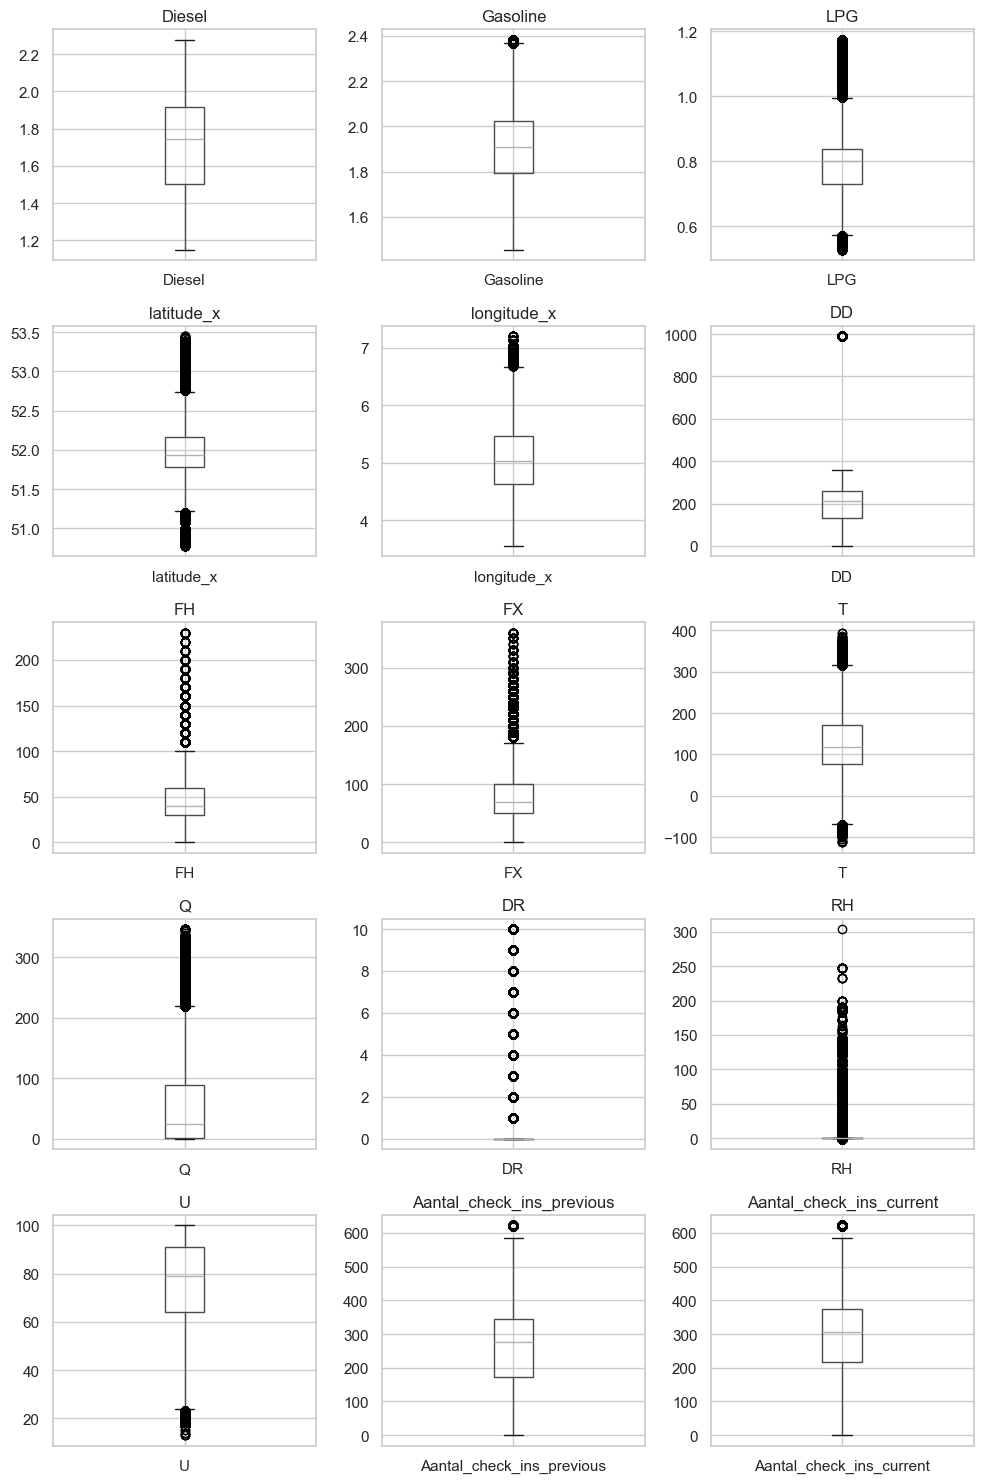

In [37]:
columns_to_plot = ['Diesel', 'Gasoline', 'LPG', 'latitude_x', 'longitude_x',
                   'DD', 'FH', 'FX', 'T', 'Q', 'DR', 'RH', 'U',
                   'Aantal_check_ins_previous', 'Aantal_check_ins_current']

# Create a DataFrame containing only the specified columns
plot_cols = df[columns_to_plot]

# Create a 3x5 grid of subplots
fig, axes = plt.subplots(5,3, figsize=(10, 15))

# Flatten the axes array to easily iterate over all subplots
axes = axes.flatten()

# Loop through each column and create a boxplot in the corresponding subplot
for i, col in enumerate(plot_cols.columns):
    plot_cols.boxplot(column=col, ax=axes[i])
    axes[i].set_title(col)  # Set title for each subplot

# Adjust layout to prevent overlapping titles
plt.tight_layout()

# Show the plot
plt.show()


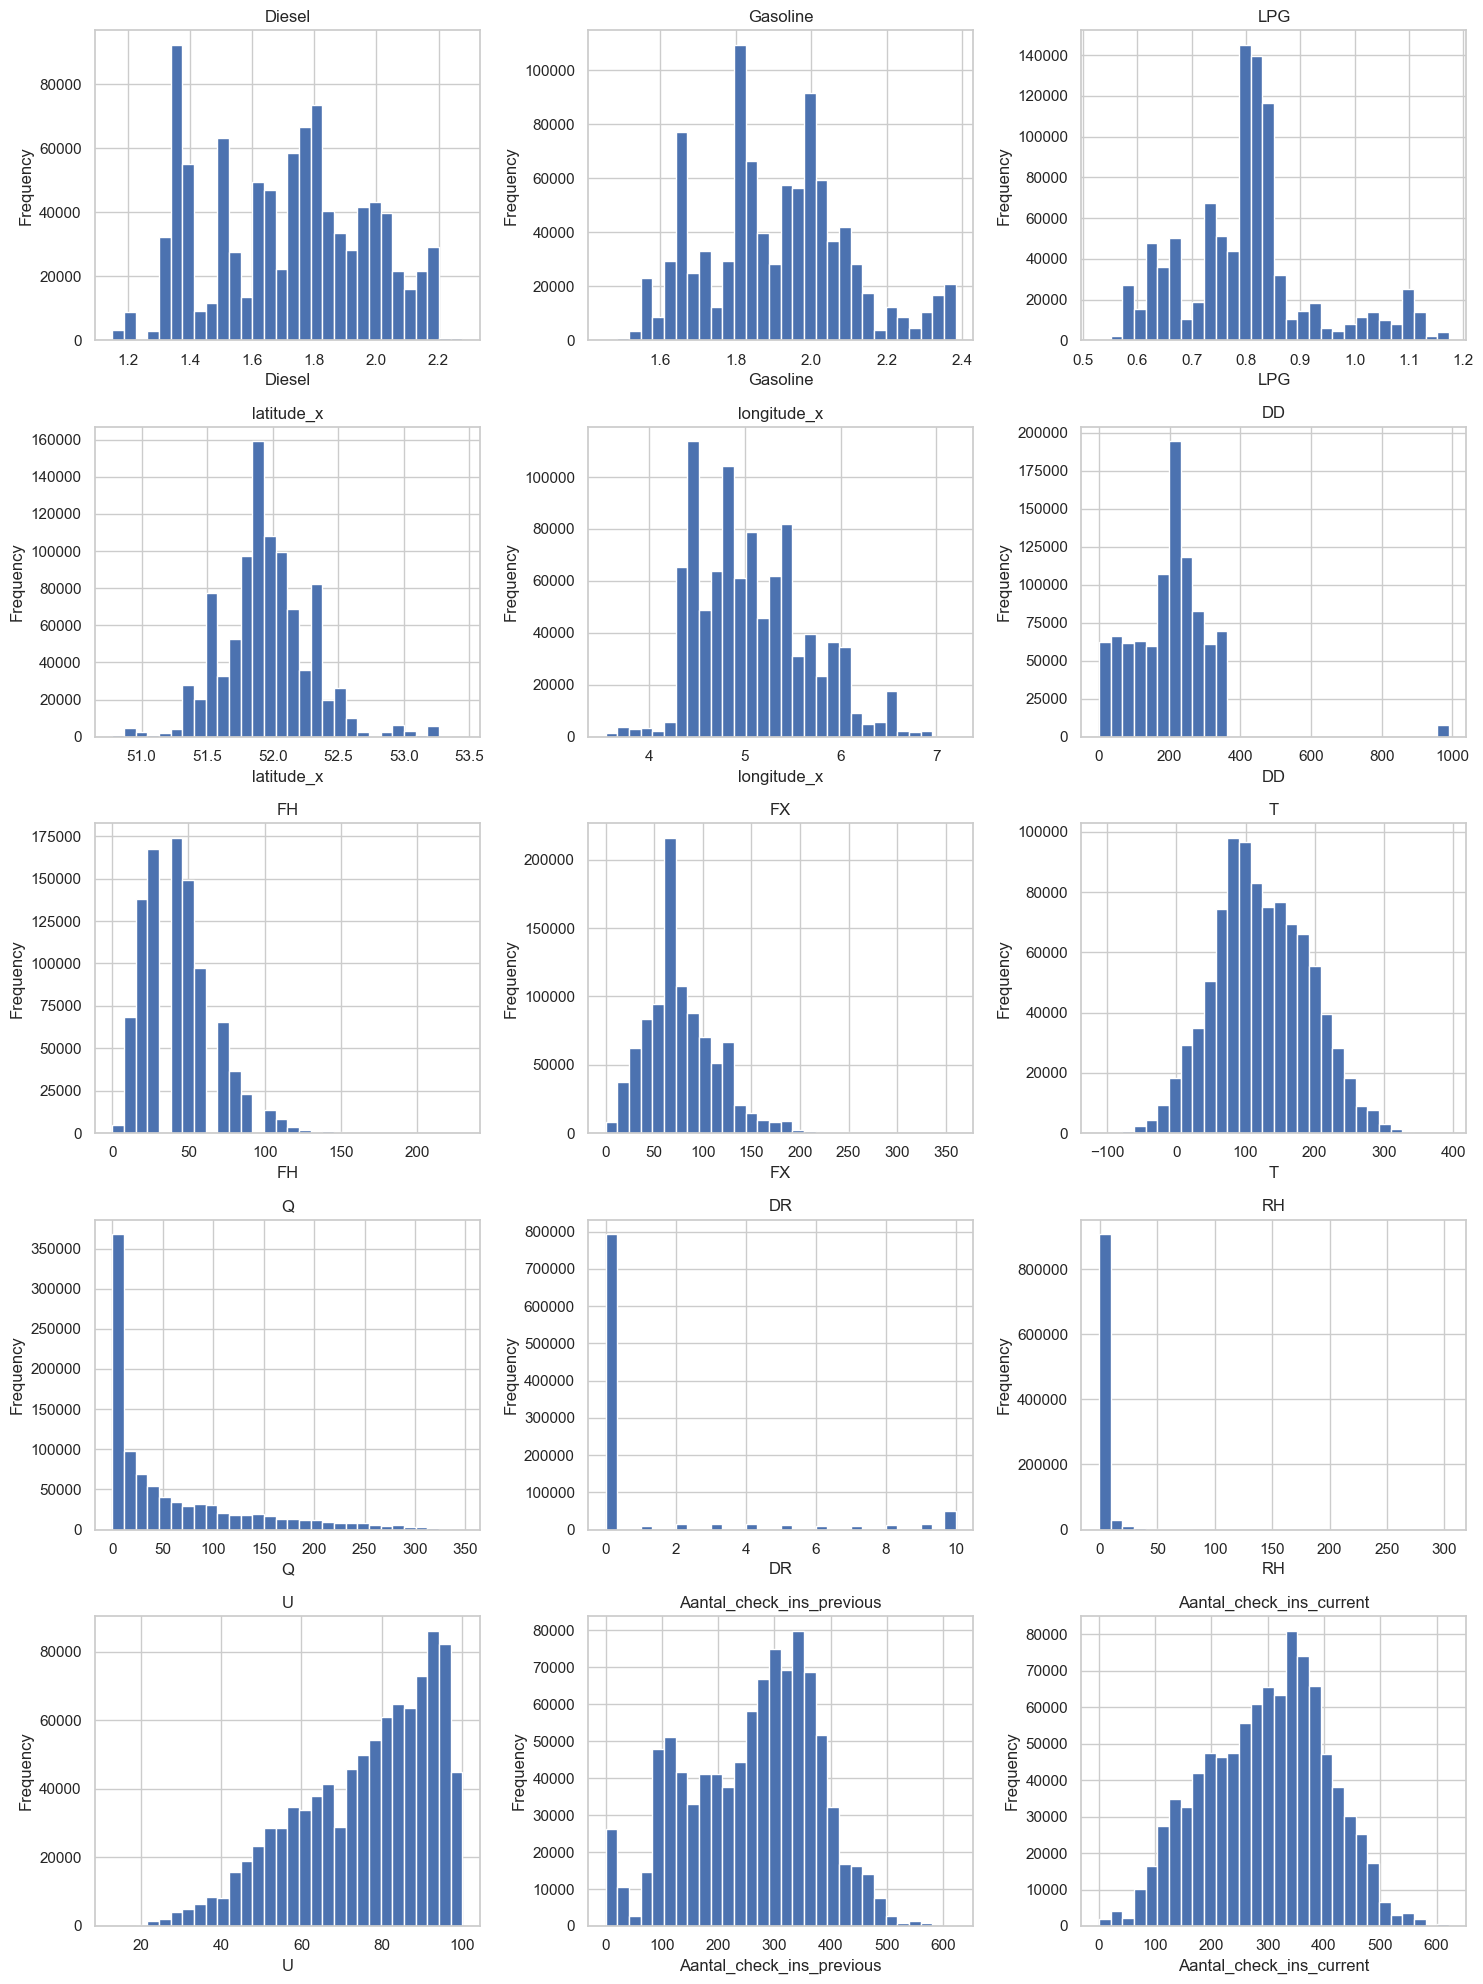

In [38]:

columns_to_plot = ['Diesel', 'Gasoline', 'LPG', 'latitude_x', 'longitude_x',
                   'DD', 'FH', 'FX', 'T', 'Q', 'DR', 'RH', 'U',
                   'Aantal_check_ins_previous', 'Aantal_check_ins_current']

# Create a DataFrame containing only the specified columns
plot_cols = df[columns_to_plot]

# Create a 5x3 grid of subplots (15 subplots for 14 columns, the last one will be empty)
fig, axes = plt.subplots(5, 3, figsize=(15, 20))

# Flatten the axes array to easily iterate over all subplots
axes = axes.flatten()

# Loop through each column and create a histogram in the corresponding subplot
for i, col in enumerate(plot_cols.columns):
    plot_cols[col].plot(kind='hist', ax=axes[i], bins=30)  # You can adjust the number of bins as needed
    axes[i].set_title(col)  # Set title for each subplot
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Adjust layout to prevent overlapping titles
plt.tight_layout()

# Show the plot
plt.show()

In [39]:
# Generate the histogram
plt.figure(figsize=(10, 6))
df['FileZwaarte'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('FileZwaarte')
plt.ylabel('Frequency')
plt.title('Frequency Histogram of FileZwaarte')
plt.show()

['NLSitNummer',
 'FileZwaarte',
 'GemLengte',
 'FileDuur',
 'HectometerKop',
 'HectometerStaart',
 'RouteLet',
 'RouteNum',
 'RouteOms',
 'hectometreringsrichting',
 'OorzaakCode',
 'DatumTijdFileBegin',
 'DatumTijdFileEind',
 'DatumFileBeginInt',
 'Diesel',
 'Gasoline',
 'LPG',
 'latitude_x',
 'longitude_x',
 'provincie_x',
 'latitude_y',
 'longitude_y',
 'HourOfDay',
 'station_code',
 'DD',
 'FH',
 'FF',
 'FX',
 'T',
 'Q',
 'DR',
 'RH',
 'P',
 'N',
 'U',
 'M',
 'R',
 'S',
 'O',
 'Y',
 'Aantal_check_ins_current',
 'Aantal_check_ins_previous',
 'freeday',
 'Year',
 'DayOfWeek',
 'MonthOfYear',
 'SecondsSinceMidnight_Begin',
 'COVID',
 'RouteLet_encoded',
 'DayOfWeek_encoded',
 'MonthOfYear_encoded',
 'provincie_x_encoded',
 'TrajVan_encoded',
 'TrajNaar_encoded',
 'KopWegvakVan_encoded',
 'KopWegvakNaar_encoded',
 'TrajCombination_encoded',
 'RouteOms_encoded']

In [ ]:
perc = df[df['FileDuur'] < 6]

fd = perc['FileDuur']
# Visualize the new distribution
plt.figure(figsize=(10, 6))
plt.hist(fd, bins=50, color='green', edgecolor='black', alpha=0.7)
plt.xlabel('Transformed Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()